# Training the U-NET
U-NET consists of an encoder / decoder structure.

Define the data directories. The directories need to be updated when a different encoder / decoder needs to be trained.
* data_dir contains the entire data-set.

After creating the train / test splits:
* train_dir will contain the train-set.
* validation_dir will contain the validation-set.

In [1]:
import os

os.environ['SM_FRAMEWORK'] = 'tf.keras'

import cv2
import shutil
import numpy as np
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import segmentation_models as sm

from pathlib import Path


root_dir = os.path.join('..', 'traindata')
data_dir = os.path.join(root_dir, 'data')
train_dir = os.path.join(root_dir, 'train')
validation_dir = os.path.join(root_dir, 'validation')
Path(train_dir).mkdir(parents=True, exist_ok=True)
Path(validation_dir).mkdir(parents=True, exist_ok=True)

# Sub-directories containing images and masks.
images_dir, masks_dir = 'images', 'masks'

print(tf.__version__)

Segmentation Models: using `tf.keras` framework.
2.10.0


In [2]:
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
print([x.name for x in local_device_protos if 'GPU' in x.name])

[]


In [3]:
try:
  shutil.rmtree(train_dir)
except:
  pass
os.mkdir(train_dir)

try:
  shutil.rmtree(validation_dir)
except:
  pass
os.mkdir(validation_dir)

split = .8
file_names = list(os.listdir(os.path.join(data_dir, masks_dir)))
split_index = int(split * len(file_names))

try:
  shutil.rmtree(os.path.join(train_dir, images_dir))
except:
  pass
os.mkdir(os.path.join(train_dir, images_dir))

try:
  shutil.rmtree(os.path.join(train_dir, masks_dir))
except:
  pass
os.mkdir(os.path.join(train_dir, masks_dir))

np.random.shuffle(file_names)
train_names = file_names[:split_index]

for i, file_name in enumerate(train_names):
  shutil.copyfile(os.path.join(data_dir, images_dir, file_name),
                  os.path.join(train_dir, images_dir, str(i) + file_name))
  shutil.copyfile(os.path.join(data_dir, masks_dir, file_name),
                  os.path.join(train_dir, masks_dir, str(i) + file_name))

try:
  shutil.rmtree(os.path.join(validation_dir, images_dir))
except:
  pass

os.mkdir(os.path.join(validation_dir, images_dir))

try:
  shutil.rmtree(os.path.join(validation_dir, masks_dir))
except:
  pass

os.mkdir(os.path.join(validation_dir, masks_dir))

validation_names = file_names[split_index:]
for i, file_name in enumerate(validation_names):
  shutil.copyfile(os.path.join(data_dir, images_dir, file_name),
                  os.path.join(validation_dir, images_dir, str(i) + file_name))
  shutil.copyfile(os.path.join(data_dir, masks_dir, file_name),
                  os.path.join(validation_dir, masks_dir, str(i) + file_name))

Define the augmentations to use for augmenting the data-set.

In [6]:
image_shape = (1664, 1024)

augmenter = A.Compose([
    A.GaussNoise(p=.1),
    A.OneOf(
        [
            A.HueSaturationValue(10, 10, 10, p=1),
            A.RandomBrightnessContrast(0.1, 0.1, p=1),
            A.FancyPCA(0.05, p=1),
        ],
        p=.25,
    ),
    A.HorizontalFlip(p=.25),
    A.VerticalFlip(p=.25),
    A.ToGray(p=.35),
    A.Rotate((180, 180), p=.25)
])

In [7]:
preprocess_input = sm.get_preprocessing('efficientnetb5')


def data_generator(data_path, augmentation=False, seed=1): 
  image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()

  image_generator = image_data_generator.flow_from_directory(
        data_path, classes=[images_dir], class_mode=None,
        color_mode='rgb', target_size=image_shape, batch_size=1,
        seed=seed)

  mask_generator = image_data_generator.flow_from_directory(
      data_path, classes=[masks_dir], class_mode=None,
      color_mode='grayscale', target_size=image_shape, batch_size=1,
      seed=seed)

  for img, mask in zip(image_generator, mask_generator):
    img = np.squeeze(img).astype(np.uint8)
    mask = np.squeeze(mask).astype(np.uint8)

    if augmentation:
        augmented = augmenter(image=img, mask=mask)
        img, mask = augmented['image'], augmented['mask']

    img = preprocess_input(img)   
    img, mask = np.expand_dims(img, axis=0), np.expand_dims(mask, axis=0)

    mask = (mask / 255).astype(np.float32)

    yield img, mask

Found 9436 images belonging to 1 classes.
Found 9436 images belonging to 1 classes.


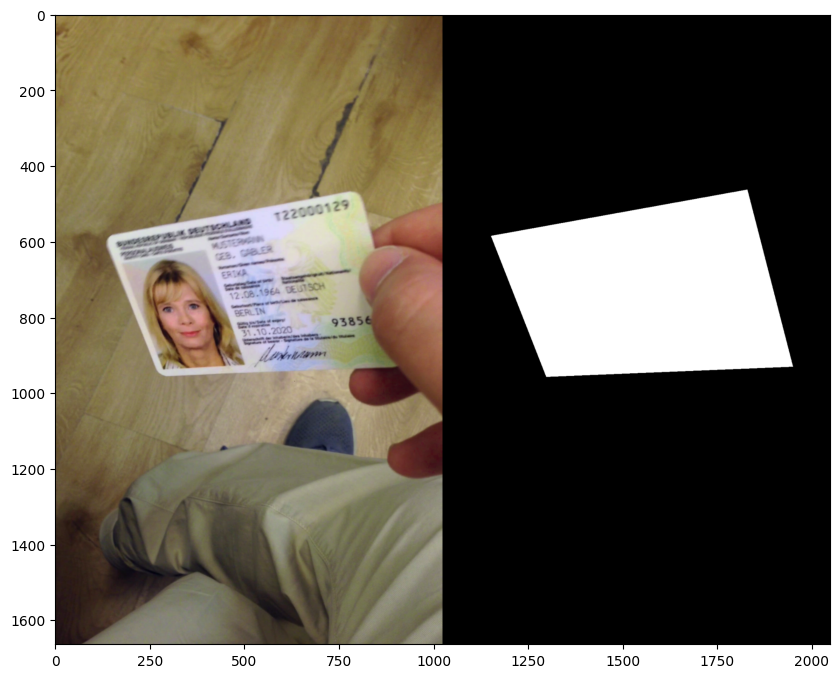

In [8]:
train_generator_instance = data_generator(train_dir, augmentation=True, seed=42)

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

for _ in range(1):
    image, mask = next(train_generator_instance)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(np.hstack((normalize(np.squeeze(image[0])), cv2.cvtColor(np.squeeze(mask[0]), cv2.COLOR_GRAY2RGB))))
    plt.show()

validation_generator_instance = data_generator(validation_dir, augmentation=False, seed=1)

In [9]:
weights_checkpoint_dir = os.path.join(root_dir, 'weights.h5')

Initialize the model. When the encoder is trained, it is de-frozen.

In [10]:
model = sm.Unet('efficientnetb5', classes=1, activation='sigmoid')

In [11]:
optim = tf.keras.optimizers.Adam(1e-4)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [
    sm.metrics.IOUScore(threshold=.5),
    sm.metrics.FScore(threshold=.5),
]

model.compile(optim, total_loss, metrics)

In [12]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    weights_checkpoint_dir, monitor='val_loss', save_best_only=True, mode='min')

callbacks = [
    model_checkpoint,
]

In [36]:
model.fit(
    train_generator_instance,
    steps_per_epoch=1000,
    epochs=200,
    verbose=1,
    validation_data=validation_generator_instance,
    validation_steps=200,
    shuffle=True,
    callbacks=callbacks)

Epoch 1/200
   1/1000 [..............................] - ETA: 28:56:58 - loss: 1.3723 - iou_score: 0.0204 - f1-score: 0.0401

KeyboardInterrupt: 

Save weights

In [ ]:
model.save_weights(os.path.join(root_dir, 'weights.h5'))